# Import Libraries


In [1]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
import numpy as np
import pandas as pd
import pickle
import os
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import re
import matplotlib.pyplot as plt
import seaborn as sns
import random

2025-05-05 23:10:03.602175: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-05 23:10:03.613187: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746461403.625169    9913 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746461403.628754    9913 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746461403.638741    9913 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# Load Essay Dataset

In [2]:
stdset = pd.read_excel("datasets/esai_siswa_24_25.xlsx")
gptset = pd.read_csv("datasets/esai_gpt_24_25.csv")

In [3]:
stdset.info()
stdset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327 entries, 0 to 326
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   teks_esai     327 non-null    object
 1   nama          327 non-null    object
 2   asal_sekolah  327 non-null    object
 3   tahun         327 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 10.3+ KB


,teks_esai,nama,asal_sekolah,tahun
0,P3KTAS: Menciptakan Persatuan dalam Masyarakat...,Achmad Muchasan Nafi,SMA PRIBADI BANDUNG,2024
1,Apakah Anda memiliki teman atau saudara yang b...,Achmad Muchasan Nafi,SMA PRIBADI BANDUNG,2024
2,Dengan adanya perbedaan budaya tersebut banyak...,Achmad Muchasan Nafi,SMA PRIBADI BANDUNG,2024
3,Kasus diskriminasi terbesar di Indonesia lainn...,Achmad Muchasan Nafi,SMA PRIBADI BANDUNG,2024
4,Diskriminasi merupakan salah satu faktor yang ...,Achmad Muchasan Nafi,SMA PRIBADI BANDUNG,2024


In [4]:
gptset.info()
gptset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Response  273 non-null    object
dtypes: object(1)
memory usage: 2.3+ KB


,Response
0,harmoni keberagaman: jalan menuju kejayaan ba...
1,di tengah bising derap langkah modernitas yang...
2,kilas balik pada sejarah panjang negeri ini me...
3,"namun, mengelola keragaman tidaklah semudah me..."
4,salah satu modal utama untuk mencapai kejayaan...


In [5]:
def preprocess_text(text):
    """
    Preprocessing text:
    - Convert text to lowercase
    - Cleaning up excess whitespace
    - Keeps the text as a whole paragraph
    
    Args:
        text (str): input text.
        
    Returns:
        str: the processed text or None if invalid.
    """
    if not isinstance(text, str) or text.strip() == "":
        return None
    
    text = text.lower().strip()
    text = re.sub(r'\s+', ' ', text)
    text = text.replace('_x000d_', '')
    return text

# Essay Informations

In [6]:
# Count number of texts per author
author_counts = stdset.groupby('nama')['teks_esai'].count().sort_values(ascending=False)
total_authors = len(author_counts)

# Count sentences in each text
def count_sentences(text):
    if not isinstance(text, str):
        return 0
    # Clean text first using existing preprocess_text function
    text = preprocess_text(text)
    if not text:
        return 0
    # Split by common sentence endings
    sentences = re.split('[.!?]+', text)
    # Remove empty strings
    sentences = [s.strip() for s in sentences if s.strip()]
    return len(sentences)

# Apply sentence counting to teks_esai
sentence_counts = stdset['teks_esai'].apply(count_sentences)

# Calculate statistics
single_sentence = sum(sentence_counts == 1)
multiple_sentences = sum(sentence_counts > 1)
total_texts = len(sentence_counts)

# Create a DataFrame to show statistics per author
author_stats = pd.DataFrame()
author_stats['nama'] = author_counts.index
author_stats['single_sentence'] = [sum(sentence_counts[stdset['nama'] == author] == 1) for author in author_stats['nama']]
author_stats['multiple_sentences'] = [sum(sentence_counts[stdset['nama'] == author] > 1) for author in author_stats['nama']]
author_stats['total_texts'] = author_counts.values

# Display the table
print("Statistics per Author:")
print(author_stats.to_string(index=False))

# Calculate and display summary statistics
print("\nStudent Summary:")
print(f"Total authors: {total_authors}")
print(f"Total texts: {total_texts}")
print(f"Total single sentences: {single_sentence}")
print(f"Total multiple sentences: {multiple_sentences}")
print(f"Minimum multiple sentences per author: {author_stats['multiple_sentences'].min()}")
print(f"Maximum multiple sentences per author: {author_stats['multiple_sentences'].max()}")
mean_multiple_sentences = author_stats['multiple_sentences'].mean()
print(f"Mean multiple sentences per author: {mean_multiple_sentences:.2f}")


Statistics per Author:
                                           nama  single_sentence  multiple_sentences  total_texts
                     Syarifuddin Muhammad Wahib                2                  28           30
                       Nandra Nadhesya Larasati                2                  18           20
                               Arif Nurfadlilah                5                  15           20
                        Nadia Izzati Firmansyah                1                  19           20
                                Dewi Tyas Utami                1                  18           19
                                   Levi Linardi                1                  18           19
                                 Shulhan Tasdiq                2                  15           17
                      Sekar Anggita Widyatamaka                1                  16           17
                             Belva Aqila Irwani                1                  15           

In [7]:
# Create subsets based on year
author_stats_2024 = author_stats[author_stats['nama'].isin(stdset[stdset['tahun'] == 2024]['nama'].unique())]
author_stats_2025 = author_stats[author_stats['nama'].isin(stdset[stdset['tahun'] == 2025]['nama'].unique())]

# Print statistics for 2024
print("\nStatistics for 2024:")
print(f"Total authors: {len(author_stats_2024)}")
print(f"Total texts: {author_stats_2024['total_texts'].sum()}")
print(f"Total single sentences: {author_stats_2024['single_sentence'].sum()}")
print(f"Total multiple sentences: {author_stats_2024['multiple_sentences'].sum()}")
print(f"Minimum multiple sentences per author: {author_stats_2024['multiple_sentences'].min()}")
print(f"Maximum multiple sentences per author: {author_stats_2024['multiple_sentences'].max()}")
print(f"Mean multiple sentences per author: {author_stats_2024['multiple_sentences'].mean():.2f}")

# Print statistics for 2025  
print("\nStatistics for 2025:")
print(f"Total authors: {len(author_stats_2025)}")
print(f"Total texts: {author_stats_2025['total_texts'].sum()}")
print(f"Total single sentences: {author_stats_2025['single_sentence'].sum()}")
print(f"Total multiple sentences: {author_stats_2025['multiple_sentences'].sum()}")
print(f"Minimum multiple sentences per author: {author_stats_2025['multiple_sentences'].min()}")
print(f"Maximum multiple sentences per author: {author_stats_2025['multiple_sentences'].max()}")
print(f"Mean multiple sentences per author: {author_stats_2025['multiple_sentences'].mean():.2f}")



Statistics for 2024:
Total authors: 10
Total texts: 154
Total single sentences: 12
Total multiple sentences: 142
Minimum multiple sentences per author: 12
Maximum multiple sentences per author: 19
Mean multiple sentences per author: 14.20

Statistics for 2025:
Total authors: 10
Total texts: 173
Total single sentences: 17
Total multiple sentences: 156
Minimum multiple sentences per author: 10
Maximum multiple sentences per author: 28
Mean multiple sentences per author: 15.60


In [8]:
sentence_counts = gptset['Response'].apply(count_sentences)

# Calculate statistics
single_sentence = sum(sentence_counts == 1)
multiple_sentences = sum(sentence_counts > 1)
total_texts = len(sentence_counts)

print("\nChatGPT Summary:")
print(f"Total texts: {total_texts}")
print(f"Total single sentences: {single_sentence}")
print(f"Total multiple sentences: {multiple_sentences}")
print(f"Minimum multiple sentences per author: {author_stats['multiple_sentences'].min()}")
print(f"Maximum multiple sentences per author: {author_stats['multiple_sentences'].max()}")
mean_multiple_sentences = author_stats['multiple_sentences'].mean()
print(f"Mean multiple sentences per author: {mean_multiple_sentences:.2f}")


ChatGPT Summary:
Total texts: 273
Total single sentences: 20
Total multiple sentences: 253
Minimum multiple sentences per author: 10
Maximum multiple sentences per author: 28
Mean multiple sentences per author: 14.90


# Load Dataset for Training

In [9]:
#load dataset
std_txt = []
gpt_txt = []

# Process Student essay
for text in stdset['teks_esai']:
    processed = preprocess_text(text)
    if processed:
        std_txt.append(processed)

# Process ChatGPT essay
for text in gptset['Response']:
    processed = preprocess_text(text)
    if processed:
        gpt_txt.append(processed)


# Show total number of processed texts
print(f"Total student text: {len(std_txt)}")
print(f"Total ChatGPT text: {len(gpt_txt)}")

Total student text: 327
Total ChatGPT text: 273


In [10]:
texts = std_txt + gpt_txt
labels = [0] * len(std_txt) + [1] * len(gpt_txt)
data = pd.DataFrame({'text': texts, 'label': labels})

train_data, test_data = train_test_split(
    data, test_size=0.2, random_state=42, stratify=data['label']
)

print(f"Initial training set: {len(train_data)} samples")
print(f"Initial test set: {len(test_data)} samples")
print(f"Initial training distribution: Student={sum(train_data['label']==0)}, ChatGPT={sum(train_data['label']==1)}")


X_train = train_data[['text']]
y_train = train_data['label']

undersampler = RandomUnderSampler(random_state=42)
X_train_indices = pd.DataFrame({'index': range(len(X_train))})
X_resampled_indices, y_resampled = undersampler.fit_resample(X_train_indices, y_train)

selected_indices = X_resampled_indices['index'].values

balanced_train_data = train_data.iloc[selected_indices].reset_index(drop=True)

removed_indices = set(range(len(train_data))) - set(selected_indices)
removed_samples = train_data.iloc[list(removed_indices)]

test_set = pd.concat([test_data, removed_samples]).reset_index(drop=True)

train_set, val_set = train_test_split(
    balanced_train_data, test_size=0.05/0.80, random_state=42, stratify=balanced_train_data['label']
)

# Print final dataset statistics
print("\nAfter undersampling:")
print(f"Training set: {len(train_set)} samples (Student={sum(train_set['label']==0)}, ChatGPT={sum(train_set['label']==1)})")
print(f"Validation set: {len(val_set)} samples (Student={sum(val_set['label']==0)}, ChatGPT={sum(val_set['label']==1)})")
print(f"Test set: {len(test_set)} samples (Student={sum(test_set['label']==0)}, ChatGPT={sum(test_set['label']==1)})")
print((train_set))

Initial training set: 480 samples
Initial test set: 120 samples
Initial training distribution: Student=262, ChatGPT=218

After undersampling:
Training set: 408 samples (Student=204, ChatGPT=204)
Validation set: 28 samples (Student=14, ChatGPT=14)
Test set: 164 samples (Student=109, ChatGPT=55)
                                                  text  label
382  mengintegrasikan keberagaman dalam kehidupan s...      1
85   sebagai bangsa indonesia, kesempatan ini dapat...      0
290  pertama-tama, untuk bisa benar-benar mengolah ...      1
103  perjuangan pemerintah dalam mengajukan peresmi...      0
406  seperti halnya mengolah tanah untuk bercocok t...      1
..                                                 ...    ...
423  oleh karena itu, hidup yang diolah bukanlah se...      1
250  media massa dan media sosial juga memiliki per...      1
260  di sisi lain, kemampuan untuk mengolah hidup a...      1
138  kata keberagaman dalam kamus besar bahasa indo...      0
187  masyarakat penggun

# Initialize BERT Tokenizer

In [11]:
# Initialize IndoBERT tokenizer
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")

# Tokenize function
def tokenize_text(texts, max_length=256):
    """
    Text tokenization using IndoBERT tokenizer.
    
    Args:
        texts (list): List of texts to be tokenized.
        max_length (int): Maximum token length.
        
    Returns:
        dict: Tokenized result, including input_ids and attention_mask.
    """
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )

In [12]:
# Tokenize student and ChatGPT essays

print("Tokenize student essay...")
std_tokens = tokenize_text(std_txt)
print("Tokenize ChatGPT essay...")
gpt_tokens = tokenize_text(gpt_txt)

print("Tokenize student essay (Training Set)...")
std_tr_tokens = tokenize_text(train_set[train_set['label'] == 0]['text'].tolist())
print("Tokenize ChatGPT essay (Training Set)...")
gpt_tr_tokens = tokenize_text(train_set[train_set['label'] == 1]['text'].tolist())

print("Tokenize student essay (Validation Set)...")
std_va_tokens = tokenize_text(val_set[val_set['label'] == 0]['text'].tolist())
print("Tokenize ChatGPT essay (Validation Set)...")
gpt_va_tokens = tokenize_text(val_set[val_set['label'] == 1]['text'].tolist())

print("Tokenize student essay (Test Set)...")
std_te_tokens = tokenize_text(test_set[test_set['label'] == 0]['text'].tolist())
print("Tokenize ChatGPT essay (Test Set)...")
gpt_te_tokens = tokenize_text(test_set[test_set['label'] == 1]['text'].tolist())

# Display tokenization results (example: Student)
print("\nExample of tokenization results:")
print(std_tr_tokens['input_ids'][:3])  # Input token ID
print(std_tr_tokens['attention_mask'][:3])  # Attention mask

Tokenize student essay...


I0000 00:00:1746461409.108675    9913 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5529 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


Tokenize ChatGPT essay...
Tokenize student essay (Training Set)...
Tokenize ChatGPT essay (Training Set)...
Tokenize student essay (Validation Set)...
Tokenize ChatGPT essay (Validation Set)...
Tokenize student essay (Test Set)...
Tokenize ChatGPT essay (Test Set)...

Example of tokenization results:
AttributeError: module 'ml_dtypes' has no attribute 'float4_e2m1fn'
tf.Tensor(
[[    2   242  1642   300 30468  1947    92   173  5246    90  1294  6060
   5182    34  2970   664 30470    79   975 30468  2204   173  6113   879
   8223  1241   705   176 13580 30470   300   573   830  1085   234   664
   9468   211   119  6296  1876   494   500   256 30470     3     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0  

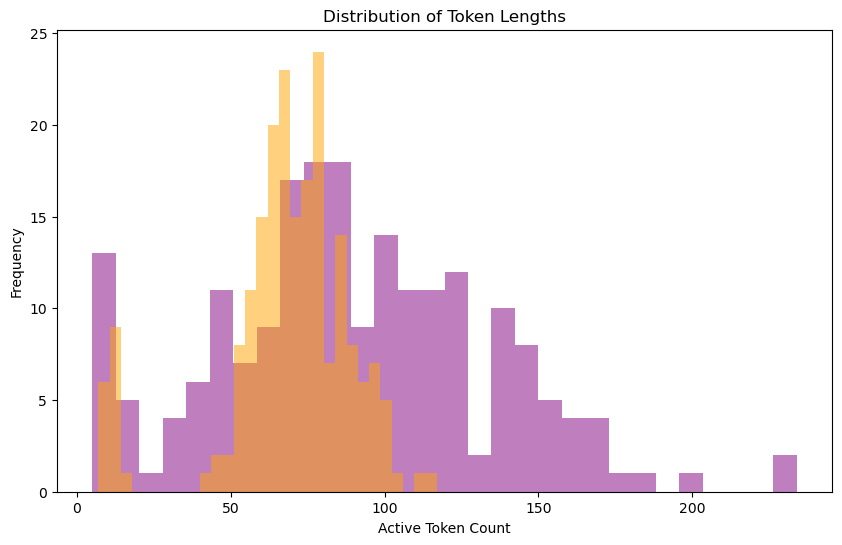

Average token length for Student: 89.40
Percentage truncated for Student: 0.00%
Average token length for ChatGPT: 68.35
Percentage truncated for ChatGPT: 0.00%


In [13]:
std_tr_lengths = [sum(mask) for mask in std_tr_tokens['attention_mask'].numpy()]
gpt_tr_lengths = [sum(mask) for mask in gpt_tr_tokens['attention_mask'].numpy()]

plt.figure(figsize=(10, 6))
plt.hist(std_tr_lengths, bins=30, alpha=0.5, label='Student', color='purple')
plt.hist(gpt_tr_lengths, bins=30, alpha=0.5, label='ChatGPT', color='orange')
plt.title('Distribution of Token Lengths')
plt.xlabel('Active Token Count')
plt.ylabel('Frequency')
plt.show()
print(f"Average token length for Student: {np.mean(std_tr_lengths):.2f}")
print(f"Percentage truncated for Student: {sum(l == 256 for l in std_tr_lengths) / len(std_tr_lengths) * 100:.2f}%")
print(f"Average token length for ChatGPT: {np.mean(gpt_tr_lengths):.2f}")
print(f"Percentage truncated for ChatGPT: {sum(l == 256 for l in gpt_tr_lengths) / len(gpt_tr_lengths) * 100:.2f}%")

In [14]:
# Decoding tokens for ensuring correctness
sample_text = gpt_txt[0]
sample_tokens = tokenizer.encode(sample_text)
print(f"Teks asli: {sample_text}")
print(f"Token ID: {sample_tokens}")
print(f"Token dekode: {tokenizer.decode(sample_tokens)}")

Teks asli: harmoni keberagaman: jalan menuju kejayaan bangsa
Token ID: [2, 20596, 21585, 30472, 795, 1894, 16071, 1642, 3]
Token dekode: [CLS] harmoni keberagaman : jalan menuju kejayaan bangsa [SEP]


In [15]:
# Save tokenized data
tokenized_data = {
    'student': std_tokens,
    'chatgpt': gpt_tokens
}

# Save input_ids and attention_mask as numpy arrays
tokenized_numpy = {
    'student': {
        'input_ids': std_tokens['input_ids'].numpy(),
        'attention_mask': std_tokens['attention_mask'].numpy()
    },
    'chatgpt ': {
        'input_ids': gpt_tokens ['input_ids'].numpy(),
        'attention_mask': gpt_tokens ['attention_mask'].numpy()
    }
}

os.makedirs("paper", exist_ok=True)

with open('paper/tokenized_data.pkl', 'wb') as f:
    pickle.dump(tokenized_numpy, f)

# Build IndoBERT Semantic Similarity Model

In [16]:
# Load IndoBERT model
bert_model = TFBertModel.from_pretrained("indobenchmark/indobert-base-p2")

# Freeze BERT layers
for layer in bert_model.layers:
    layer.trainable = False

# Define Bi-Encoder model
def model(bert_model):
    """
    Create a Bi-Encoder model with IndoBERT.
    
    Args:
        bert_model (TFBertModel): Base model of IndoBERT.
        
    Returns:
        tf.keras.Model: Bi-Encoder model.
    """
    # Input layer
    input_ids = tf.keras.layers.Input(shape=(256,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(256,), dtype=tf.int32, name="attention_mask")
    
    # Extract CLS token embeddings from IndoBERT
    bert_output = bert_model(input_ids, attention_mask=attention_mask)[0][:, 0, :]  # [CLS] token
    
    # Dense layer for fine-tuning
    dense1 = tf.keras.layers.Dense(256, activation="relu")(bert_output)
    dropout1 = tf.keras.layers.Dropout(0.1)(dense1)
    dense2 = tf.keras.layers.Dense(256, activation="relu")(dropout1)
    dropout2 = tf.keras.layers.Dropout(0.1)(dense2)
    dense3 = tf.keras.layers.Dense(256)(dropout2)
    
    # Output normalization (L2 normalization)
    normalized_output = tf.nn.l2_normalize(dense3, axis=1)
    
    # Semantic model
    return tf.keras.Model(inputs=[input_ids, attention_mask], outputs=normalized_output)

# Build model
semantic_model = model(bert_model)

# Show model summary
print("Model Summary:")
semantic_model.summary()


Some layers from the model checkpoint at indobenchmark/indobert-base-p2 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model Summary:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 256)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1244413   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   44         'attention_mask[0][0]']      
                             hidden_state=(None, 256, 7                        

# Create Contrastive Pairs

In [17]:
def create_contrastive_pairs(student_tokens, chatgpt_tokens, max_pairs=None):
    """
    Creates data pairs for contrastive learning with dataset-appropriate quantities.

    Args:
        student_tokens: Tokenized student text
        chatgpt_tokens_1: First set of tokenized ChatGPT text
        chatgpt_tokens_2: Second set of tokenized ChatGPT text
        max_pairs: Maximum number of pairs (optional). If None, uses all possible combinations.

    Returns:
        tuple: Dictionary of anchor, positive, negative pairs and labels, and the total number of pairs.
    """
    # Get dataset sizes
    n_student = student_tokens['input_ids'].shape[0]
    n_chatgpt = chatgpt_tokens['input_ids'].shape[0]
    
    # Calculate maximum possible combinations
    max_student_pairs = (n_student * (n_student - 1)) // 2  # student-student combinations
    max_chatgpt_pairs = (n_chatgpt * (n_chatgpt - 1)) // 2  # chatgpt-chatgpt combinations
    max_negative_pairs = n_student * n_chatgpt  # student-chatgpt combinations
    
    # Determine number of pairs to create
    if max_pairs is None:
        # Use minimum number of positive pairs for balance
        n_pos_student = min(max_student_pairs, max_chatgpt_pairs) // 2
        n_pos_chatgpt = n_pos_student
        # Limit negative pairs to balance with positives
        n_neg_pairs = min(max_negative_pairs, 2 * n_pos_student)
    else:
        # If max_pairs is specified, use that with equal proportions
        n_pos_student = max_pairs // 4
        n_pos_chatgpt = max_pairs // 4
        n_neg_pairs = max_pairs // 2
    
    # Ensure we don't exceed the maximum possible combinations
    n_pos_student = min(n_pos_student, max_student_pairs)
    n_pos_chatgpt = min(n_pos_chatgpt, max_chatgpt_pairs)
    n_neg_pairs = min(n_neg_pairs, max_negative_pairs)
    
    # Initialize arrays for data pairs
    anchor_input_ids = []
    anchor_attention_mask = []
    positive_input_ids = []
    positive_attention_mask = []
    negative_input_ids = []
    negative_attention_mask = []
    labels = []
    
    # Generate positive student-student pairs
    if n_pos_student > 0:
        # Create all possible student-student pairs
        student_pairs = [(i, j) for i in range(n_student) for j in range(i+1, n_student)]
        # Randomly select pairs
        selected_pairs = random.sample(student_pairs, n_pos_student)
        
        for idx1, idx2 in selected_pairs:
            # Anchor (student)
            anchor_input_ids.append(student_tokens['input_ids'][idx1])
            anchor_attention_mask.append(student_tokens['attention_mask'][idx1])
            
            # Positive (another student)
            positive_input_ids.append(student_tokens['input_ids'][idx2])
            positive_attention_mask.append(student_tokens['attention_mask'][idx2])
            
            # Negative (from ChatGPT)
            neg_idx = np.random.choice(n_chatgpt)
            negative_input_ids.append(chatgpt_tokens['input_ids'][neg_idx])
            negative_attention_mask.append(chatgpt_tokens['attention_mask'][neg_idx])
            
            # Label (1 for positive pair)
            labels.append(1)
    
    # Generate positive chatgpt-chatgpt pairs
    if n_pos_chatgpt > 0:
        # Create all possible chatgpt-chatgpt pairs
        chatgpt_pairs = [(i, j) for i in range(n_chatgpt) for j in range(i+1, n_chatgpt)]
        # Randomly select pairs
        selected_pairs = random.sample(chatgpt_pairs, n_pos_chatgpt)
        
        for idx1, idx2 in selected_pairs:
            # Anchor
            anchor_input_ids.append(chatgpt_tokens['input_ids'][idx1])
            anchor_attention_mask.append(chatgpt_tokens['attention_mask'][idx1])
            
            # Positive
            positive_input_ids.append(chatgpt_tokens['input_ids'][idx2])
            positive_attention_mask.append(chatgpt_tokens['attention_mask'][idx2])
            
            # Negative (from Student)
            neg_idx = np.random.choice(n_student)
            negative_input_ids.append(student_tokens['input_ids'][neg_idx])
            negative_attention_mask.append(student_tokens['attention_mask'][neg_idx])
            
            # Label (1 for positive pair)
            labels.append(1)
    
    # Generate negative student-chatgpt pairs
    if n_neg_pairs > 0:
        # Create all possible student-chatgpt pairs
        negative_pairs = [(i, j) for i in range(n_student) for j in range(n_chatgpt)]
        # Randomly select pairs
        selected_pairs = random.sample(negative_pairs, n_neg_pairs)
        
        for student_idx, chatgpt_idx in selected_pairs:
            # Anchor (Student)
            anchor_input_ids.append(student_tokens['input_ids'][student_idx])
            anchor_attention_mask.append(student_tokens['attention_mask'][student_idx])
            
            # Negative (ChatGPT)
            negative_input_ids.append(chatgpt_tokens['input_ids'][chatgpt_idx])
            negative_attention_mask.append(chatgpt_tokens['attention_mask'][chatgpt_idx])
            
            # Positive (another Student different from anchor)
            available_pos = [i for i in range(n_student) if i != student_idx]
            if available_pos:  # Ensure there are available indices
                pos_idx = np.random.choice(available_pos)
                positive_input_ids.append(student_tokens['input_ids'][pos_idx])
                positive_attention_mask.append(student_tokens['attention_mask'][pos_idx])
                
                # Label (0 for negative pair)
                labels.append(0)
    
    # Count actual pairs created
    actual_pairs = len(labels)
    
    # Convert to tensors and return
    return {
        'anchor': {
            'input_ids': tf.convert_to_tensor(anchor_input_ids, dtype=tf.int32),
            'attention_mask': tf.convert_to_tensor(anchor_attention_mask, dtype=tf.int32)
        },
        'positive': {
            'input_ids': tf.convert_to_tensor(positive_input_ids, dtype=tf.int32),
            'attention_mask': tf.convert_to_tensor(positive_attention_mask, dtype=tf.int32)
        },
        'negative': {
            'input_ids': tf.convert_to_tensor(negative_input_ids, dtype=tf.int32),
            'attention_mask': tf.convert_to_tensor(negative_attention_mask, dtype=tf.int32)
        },
        'labels': tf.convert_to_tensor(labels, dtype=tf.float32)
    }, actual_pairs

In [18]:
# Create contrastive pairs
std_gpt_tr_pairs, total_pairs_tr = create_contrastive_pairs(std_tr_tokens, gpt_tr_tokens, max_pairs=10000)
std_gpt_va_pairs, total_pairs_va = create_contrastive_pairs(std_va_tokens, gpt_va_tokens, max_pairs=10000)

# Show the number of pairs created
print(f"Total contrastive pairs (training) created: {total_pairs_tr}")
print(f"- Pasangan positif student-student: {sum(1 for label in std_gpt_tr_pairs['labels'].numpy() if label == 1)//2}")
print(f"- Pasangan positif chatgpt-chatgpt: {sum(1 for label in std_gpt_tr_pairs['labels'].numpy() if label == 1)//2}")
print(f"- Pasangan negatif student-chatgpt: {sum(1 for label in std_gpt_tr_pairs['labels'].numpy() if label == 0)}")


Total contrastive pairs (training) created: 10000
- Pasangan positif student-student: 2500
- Pasangan positif chatgpt-chatgpt: 2500
- Pasangan negatif student-chatgpt: 5000


# Build Triplet Input

In [19]:
# Model for training with triplet loss
def triplet_model(semantic_model):
    """
    Build a model for training with triplet loss.
    
    Args:
        semantic_model: The semantic similarity model to be trained.
        
    Returns:
         tf.keras.Model: Model for training with triplet loss.
    """
    # Input for anchor, positive, and negative
    anchor_input_ids = tf.keras.layers.Input(shape=(256,), dtype=tf.int32, name="anchor_input_ids")
    anchor_attention_mask = tf.keras.layers.Input(shape=(256,), dtype=tf.int32, name="anchor_attention_mask")
    
    positive_input_ids = tf.keras.layers.Input(shape=(256,), dtype=tf.int32, name="positive_input_ids")
    positive_attention_mask = tf.keras.layers.Input(shape=(256,), dtype=tf.int32, name="positive_attention_mask")
    
    negative_input_ids = tf.keras.layers.Input(shape=(256,), dtype=tf.int32, name="negative_input_ids")
    negative_attention_mask = tf.keras.layers.Input(shape=(256,), dtype=tf.int32, name="negative_attention_mask")
    
    # Embedding for anchor, positive, and negative
    anchor_embedding = semantic_model([anchor_input_ids, anchor_attention_mask])
    positive_embedding = semantic_model([positive_input_ids, positive_attention_mask])
    negative_embedding = semantic_model([negative_input_ids, negative_attention_mask])
    
    # measure cosine similarity
    pos_similarity = tf.reduce_sum(anchor_embedding * positive_embedding, axis=1)
    neg_similarity = tf.reduce_sum(anchor_embedding * negative_embedding, axis=1)
    
    # Model output is the similarity score
    output = tf.stack([pos_similarity, neg_similarity], axis=1)
    
    return tf.keras.Model(
        inputs=[
            anchor_input_ids, anchor_attention_mask,
            positive_input_ids, positive_attention_mask,
            negative_input_ids, negative_attention_mask
        ],
        outputs=output
    )

# Create Triplet Loss

In [20]:
# Triplet loss function
def triplet_loss(y_true, y_pred):
    """
    Triplet loss: tunes the network such that
the distance between a and p is smaller than the
distance between a and n.
    
    Args:
        y_true: not used triplet loss.
        y_pred: stack of [positive_similarity, negative_similarity].
        
    Returns:
        tf.Tensor: loss value.
    """
    pos_sim = y_pred[:, 0]
    neg_sim = y_pred[:, 1]
    margin = 0.5
    
    # Triplet loss: max(0, margin - (pos_sim - neg_sim))
    loss = tf.maximum(0., margin - (pos_sim - neg_sim))
    return tf.reduce_mean(loss)

# Train The Model

In [21]:
# Build triplet model for student vs ChatGPT essay
build_triplet = triplet_model(semantic_model)

# Compile model
build_triplet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=triplet_loss
)

# Training model Student_ChatGPT
print("Training model...")
history = build_triplet.fit(
    x=[
        std_gpt_tr_pairs['anchor']['input_ids'],
        std_gpt_tr_pairs['anchor']['attention_mask'],
        std_gpt_tr_pairs['positive']['input_ids'],
        std_gpt_tr_pairs['positive']['attention_mask'],
        std_gpt_tr_pairs['negative']['input_ids'],
        std_gpt_tr_pairs['negative']['attention_mask']
    ],
    y=std_gpt_tr_pairs['labels'], 
    epochs=10,
    batch_size=16,
    validation_data=(
    [
        std_gpt_va_pairs['anchor']['input_ids'],
        std_gpt_va_pairs['anchor']['attention_mask'],
        std_gpt_va_pairs['positive']['input_ids'],
        std_gpt_va_pairs['positive']['attention_mask'],
        std_gpt_va_pairs['negative']['input_ids'],
        std_gpt_va_pairs['negative']['attention_mask']
    ],
    std_gpt_va_pairs['labels']
    ),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    ]
)

Training model...
Epoch 1/10


I0000 00:00:1746461434.405032   10309 service.cc:152] XLA service 0x7f0a74219f30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746461434.405063   10309 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2025-05-05 23:10:34.410482: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746461434.422360   10309 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746461434.516835   10309 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 [==============================] - 314s 483ms/step - loss: 0.4087 - val_loss: 0.2995
Epoch 2/10
625/625 [==============================] - 302s 484ms/step - loss: 0.2027 - val_loss: 0.1594
Epoch 3/10
625/625 [==============================] - 303s 485ms/step - loss: 0.1351 - val_loss: 0.1376
Epoch 4/10
625/625 [==============================] - 303s 485ms/step - loss: 0.0914 - val_loss: 0.0958
Epoch 5/10
625/625 [==============================] - 308s 493ms/step - loss: 0.0648 - val_loss: 0.1784
Epoch 6/10
625/625 [==============================] - 301s 482ms/step - loss: 0.0492 - val_loss: 0.1714


# Training History

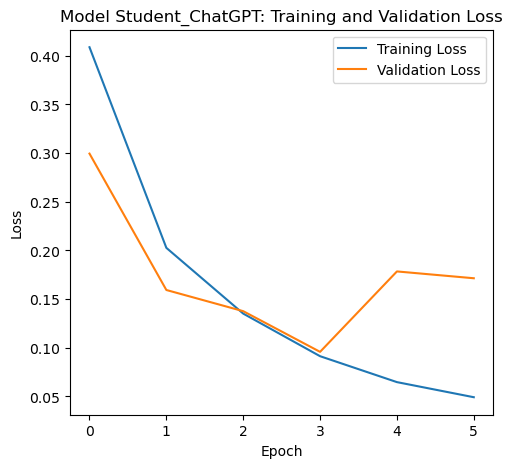

In [22]:
# Plot training history untuk model Student_ChatGPT
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Student_ChatGPT: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Generate Embeddings Function

In [23]:
import numpy as np

def gen_emb(tokens, model, batch_size=32):
    """
    Generate embeddings using IndoBERT in batches.
    
    Args:
        tokens: Token from text.
        model: IndoBERT Semantic Similarity.
        batch_size: Number of samples per batch.
        
    Returns:
        np.ndarray: Embeddings.
    """
    embeddings = []
    
    num_batches = len(tokens['input_ids']) // batch_size + (len(tokens['input_ids']) % batch_size > 0)
    
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(tokens['input_ids']))

        batch_input_ids = tokens['input_ids'][start_idx:end_idx]
        batch_attention_mask = tokens['attention_mask'][start_idx:end_idx]
        
        batch_embeddings = model([batch_input_ids, batch_attention_mask])
        
        embeddings.append(batch_embeddings)
    
    return np.concatenate(embeddings, axis=0)

# Cosine Similarity Function

In [24]:
def cos_sim(embedding1, embedding2):
    """
    Calculate similarity score using standard cosine similarity.
    
    Args:
        embedding1: First embedding (input text)
        embedding2: Second embedding (reference)
        
    Returns:
        float: Average cosine similarity score
    """
    embedding1_norm = tf.nn.l2_normalize(embedding1, axis=-1)
    embedding2_norm = tf.nn.l2_normalize(embedding2, axis=-1)
    
    similarities = tf.matmul(embedding1_norm, tf.transpose(embedding2_norm))
    similarities = tf.reshape(similarities, [-1])

    avg_similarity = tf.reduce_mean(similarities).numpy()
    return avg_similarity


# Generate Embeddings (Test Set)

In [25]:
# Generate embeddings for data test
print("Generating embeddings for Student (test set)...")
std_te_emb = gen_emb(std_te_tokens, semantic_model, batch_size=32)
print("Generating embeddings for ChatGPT (test set)...")
gpt_te_emb = gen_emb(gpt_te_tokens, semantic_model, batch_size=32)

Generating embeddings for Student (test set)...
Generating embeddings for ChatGPT (test set)...


# Measure Similarity Score (Test Set)

In [26]:
std_std_te_sim_scores = []
std_gpt_te_sim_scores = []
for emb in std_te_emb:
    avg_similarity = cos_sim(tf.expand_dims(emb, 0), std_te_emb)
    std_std_te_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt_te_emb)
    std_gpt_te_sim_scores.append(avg_similarity)

gpt_std_te_sim_scores = []
gpt_gpt_te_sim_scores = []
for emb in gpt_te_emb:
    avg_similarity = cos_sim(tf.expand_dims(emb, 0), std_te_emb)
    gpt_std_te_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt_te_emb)
    gpt_gpt_te_sim_scores.append(avg_similarity)

std_te_sim_scores = np.array([
    std_std_te_sim_scores, 
    std_gpt_te_sim_scores
])

gpt_te_sim_scores = np.array([
    gpt_std_te_sim_scores, 
    gpt_gpt_te_sim_scores
])

# Similarity Text Breakdown (Test Set)

In [27]:
all_pairs = []
pd.set_option('display.max_colwidth', None)  
pd.set_option('display.width', 1000)        
pd.set_option('display.max_rows', None)      

for i, student_text in enumerate(std_txt):
    if i >= len(std_te_emb):
        continue
        
    student_embedding = tf.expand_dims(std_te_emb[i], 0)

    for j in range(len(gpt_txt)):
        if j >= len(gpt_te_emb):
            continue

        chatgpt_embedding = tf.expand_dims(gpt_te_emb[j], 0)
        similarity = cos_sim(student_embedding, chatgpt_embedding)
        
        all_pairs.append({
            'student_idx': i,
            'chatgpt_idx': j,
            'student_text': student_text,
            'chatgpt_text': gpt_txt[j],
            'similarity_score': similarity
        })

sorted_pairs = sorted(all_pairs, key=lambda x: x['similarity_score'], reverse=True)

result_v1 = sorted_pairs[:5]

df_v1 = pd.DataFrame(result_v1)[['student_text', 'chatgpt_text', 'similarity_score']]
df_v1.columns = ['Student Essay', 'ChatGPT Essay', 'Similarity Score']

print("=== 1: Standard ===")
display(df_v1)

used_student_indices_v2 = set()
used_chatgpt_indices_v2 = set()
result_v2 = []

for pair in sorted_pairs:
    if (pair['student_idx'] in used_student_indices_v2 or 
        pair['chatgpt_idx'] in used_chatgpt_indices_v2):
        continue
    result_v2.append(pair)
    used_student_indices_v2.add(pair['student_idx'])
    used_chatgpt_indices_v2.add(pair['chatgpt_idx'])
    if len(result_v2) >= 5:
        break

df_v2 = pd.DataFrame(result_v2)[['student_text', 'chatgpt_text', 'similarity_score']]
df_v2.columns = ['Student Essay', 'ChatGPT Essay', 'Similarity Score']

print("=== 2: Unique ===")
display(df_v2)

=== 1: Standard ===


,Student Essay,ChatGPT Essay,Similarity Score
0,"stereotip negatif yang timbul tidak hanya berhenti pada titik tersebut, melainkan akan menciptakan dan memperkuat sikap negatif baru, seperti primordialisme dan etnosentrisme. primordialisme adalah ikatan-ikatan yang dimiliki seseorang dalam kehidupan sosial yang sangat berpegang teguh pada hal-hal yang dibawa sejak lahir, seperti suku bangsa, kepercayaan, ras, adat-istiadat, daerah kelahiran, dan lain sebagainya (kun maryati, dkk, 2014). secara tidak langsung, hal ini menjadi kabar baik karena kebudayaan menjadi tidak mudah dilupakan dan dapat diwariskan. namun, sikap ini sangat “rawan” terhadap keterbukaan antarras atau kelompok lain. sehingga hal ini dapat menimbulkan sikap fanatisme dan dapat menumbuhkan sikap etnosentrisme.","masyarakat indonesia perlu menyadari bahwa identitas nasional mereka dibangun atas dasar keragaman budaya. dengan menghormati perbedaan, setiap warga negara berkontribusi dalam memperkuat kohesi sosial. solidaritas yang kuat antara berbagai kelompok akan meminimalkan perpecahan dan memaksimalkan kerja sama. ini adalah modal penting bagi bangsa indonesia untuk bersaing di dunia global yang penuh dengan tantangan dan persaingan ketat.",0.940402
1,"stereotip negatif yang timbul tidak hanya berhenti pada titik tersebut, melainkan akan menciptakan dan memperkuat sikap negatif baru, seperti primordialisme dan etnosentrisme. primordialisme adalah ikatan-ikatan yang dimiliki seseorang dalam kehidupan sosial yang sangat berpegang teguh pada hal-hal yang dibawa sejak lahir, seperti suku bangsa, kepercayaan, ras, adat-istiadat, daerah kelahiran, dan lain sebagainya (kun maryati, dkk, 2014). secara tidak langsung, hal ini menjadi kabar baik karena kebudayaan menjadi tidak mudah dilupakan dan dapat diwariskan. namun, sikap ini sangat “rawan” terhadap keterbukaan antarras atau kelompok lain. sehingga hal ini dapat menimbulkan sikap fanatisme dan dapat menumbuhkan sikap etnosentrisme.","di balik berbagai perbedaan yang ada, kita harus menemukan benang merah yang menghubungkan kita sebagai bangsa—yaitu tujuan bersama untuk meraih kesejahteraan dan kedamaian. menggalang persatuan tanpa menghilangkan keberagaman adalah tantangan yang harus dapat kita tuntaskan sebagai bangsa. persatuan ini tidaklah berarti keseragaman, melainkan harmoni di tengah perbedaan.",0.926958
2,"stereotip negatif yang timbul tidak hanya berhenti pada titik tersebut, melainkan akan menciptakan dan memperkuat sikap negatif baru, seperti primordialisme dan etnosentrisme. primordialisme adalah ikatan-ikatan yang dimiliki seseorang dalam kehidupan sosial yang sangat berpegang teguh pada hal-hal yang dibawa sejak lahir, seperti suku bangsa, kepercayaan, ras, adat-istiadat, daerah kelahiran, dan lain sebagainya (kun maryati, dkk, 2014). secara tidak langsung, hal ini menjadi kabar baik karena kebudayaan menjadi tidak mudah dilupakan dan dapat diwariskan. namun, sikap ini sangat “rawan” terhadap keterbukaan antarras atau kelompok lain. sehingga hal ini dapat menimbulkan sikap fanatisme dan dapat menumbuhkan sikap etnosentrisme.","melalui kerja sama dan komitmen dari tiap individu, mimpi akan kejayaan bersama dalam keberagaman bukanlah sekadar angan-angan, melainkan sebuah realitas yang dapat diwujudkan. jadi, mari kita bersama-sama mengukir cerita indah tentang sebuah bangsa yang menjadikan keberagaman sebagai kunci dari keharmonisan dan kejayaannya.",0.926491
3,"stereotip negatif yang timbul tidak hanya berhenti pada titik tersebut, melainkan akan menciptakan dan memperkuat sikap negatif baru, seperti primordialisme dan etnosentrisme. primordialisme adalah ikatan-ikatan yang dimiliki seseorang dalam kehidupan sosial yang sangat berpegang teguh pada hal-hal yang dibawa sejak lahir, seperti suku bangsa, kepercayaan, ras, adat-istiadat, daerah kelahiran, dan lain sebagainya (kun maryati, dkk, 2014). secara tidak langsung, hal ini menjadi kabar baik karena kebudayaan menjadi tidak mudah dilupakan dan dapat

=== 2: Unique ===


,Student Essay,ChatGPT Essay,Similarity Score
0,"stereotip negatif yang timbul tidak hanya berhenti pada titik tersebut, melainkan akan menciptakan dan memperkuat sikap negatif baru, seperti primordialisme dan etnosentrisme. primordialisme adalah ikatan-ikatan yang dimiliki seseorang dalam kehidupan sosial yang sangat berpegang teguh pada hal-hal yang dibawa sejak lahir, seperti suku bangsa, kepercayaan, ras, adat-istiadat, daerah kelahiran, dan lain sebagainya (kun maryati, dkk, 2014). secara tidak langsung, hal ini menjadi kabar baik karena kebudayaan menjadi tidak mudah dilupakan dan dapat diwariskan. namun, sikap ini sangat “rawan” terhadap keterbukaan antarras atau kelompok lain. sehingga hal ini dapat menimbulkan sikap fanatisme dan dapat menumbuhkan sikap etnosentrisme.","masyarakat indonesia perlu menyadari bahwa identitas nasional mereka dibangun atas dasar keragaman budaya. dengan menghormati perbedaan, setiap warga negara berkontribusi dalam memperkuat kohesi sosial. solidaritas yang kuat antara berbagai kelompok akan meminimalkan perpecahan dan memaksimalkan kerja sama. ini adalah modal penting bagi bangsa indonesia untuk bersaing di dunia global yang penuh dengan tantangan dan persaingan ketat.",0.940402
1,harmoni dalam keberagaman: membangun indonesia sebagai lukisan indah bhinneka tunggal ika,kaleidoskop keberagaman: jalan menuju kejayaan bersama,0.897826
2,"selain provinsi bali dengan sektor pariwisatanya, indonesia memiliki kekhasan lain yaitu kain batik. kain batik telah diakui sebagai warisan budaya takbenda oleh unesco pada tahun 2009. kain batik memiliki harga jual yang cukup tinggi di pasar internasional. nilai ekspor produk batik dari januari sampai april 2023 mencapai rp. 26,7 juta. angka tersebut dapat dicapai hanya dalam waktu empat bulan. kekhasan kain batik yang dimiliki indonesia sangat beragam dan populer di mata dunia serta dapat membantu mencapai sektor ekonomi nasional.","terakhir, kejayaan dalam masyarakat multikultural dibangun atas dasar saling percaya dan keterbukaan. dengan terus mengenal dan menghargai satu sama lain, rasa persatuan dalam keberagaman akan semakin erat. pada akhirnya, keberagaman yang diolah dengan bijak akan menjadi fondasi bagi masyarakat yang tangguh, stabil, dan sejahtera, serta menginspirasi dunia dalam melihat nilai-nilai kemanusiaan secara lebih luas.",0.817257
3,kejayaan yang tidak kalah penting untuk kita capai adalah kejayaan melestarikan kesenian indonesia. peran masing-masing individu sangat dibutuhkan dalam meraih kejayaan ini. kejayaan melestarikan kesenian ini penting untuk mencapai kejayaan yang penulis sebutkan sebelumnya yakni kejayaan ekonomi dan kejayaan identitas negara. bagaimana kita bisa memasarkan kesenian kita demi kejayaan ekonomi kalau kesenian tersebut sudah punah akibat tidak adanya yang melestarikan? bagaimana kita akan berjaya membentuk identitas yang baik dengan kesenian di mata internasional jikalau kesenian itu sudah tidak ada lagi akibat minimnya pelestari atau yang mengapresiasi? karena itulah pentingnya edukasi tentang kesenian daerah untuk setiap anggota masyarakat berdasarkan daerah tempat tinggal masing-masing.,"namun demikian, kita tidak boleh menutup mata terhadap tantangan yang hadir di tengah-tengah keberagaman ini. konflik berlatar belakang etnis, agama, ataupun budaya acapkali mengemuka. untuk itu, diperlukan upaya bersama dalam menanamkan semangat toleransi dan saling pengertian, terutama di kalangan generasi muda. pendidikan multikultural harus dapat diintegrasikan ke dalam kurikulum pembelajaran agar siswa memiliki wawasan luas tentang keberagaman dan pentingnya menghargai perbedaan.",0.810213
4,"warna kulit menjadi salah satu ciri fisik yang membedakan individu satu dengan yang lain. di indonesia, keberagaman etnis, budaya, dan warna kulit bukanlah hanya sekadar wujud fisik, tetapi juga menjadi lambang kekayaan dan kebanggaan dalam masyarakat multikultural yang hidup bersama. warna kulit menjadi elemen penting yang dapat d

# Visualization of Similarity Score (Data Test)

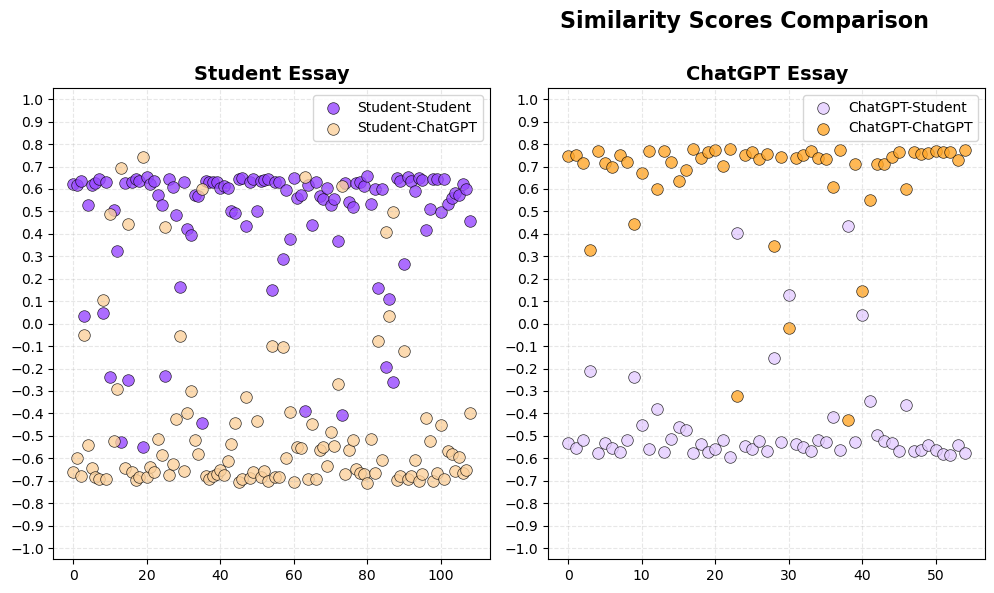

In [28]:
plt.figure(figsize=(15, 6))

student_student_color = "#9747FF"  
student_chatgpt_color = "#FCD19C"  
chatgpt_chatgpt_color = "#FFA629"  
chatgpt_student_color = "#E4CCFF"  

# Subplot 1: Student
plt.subplot(1, 3, 1)
plt.scatter(range(len(std_std_te_sim_scores)), std_std_te_sim_scores, 
            label='Student-Student', color=student_student_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.scatter(range(len(std_gpt_te_sim_scores)), std_gpt_te_sim_scores, 
            label='Student-ChatGPT', color=student_chatgpt_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.title('Student Essay', fontsize=14, fontweight='bold')
plt.ylim(-1.05, 1.05)  
plt.yticks(np.arange(-1, 1.1, 0.1))
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)

# Subplot 2: ChatGPT
plt.subplot(1, 3, 2)
plt.scatter(range(len(gpt_std_te_sim_scores)), gpt_std_te_sim_scores, 
            label='ChatGPT-Student', color=chatgpt_student_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.scatter(range(len(gpt_gpt_te_sim_scores)), gpt_gpt_te_sim_scores, 
            label='ChatGPT-ChatGPT', color=chatgpt_chatgpt_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.title('ChatGPT Essay', fontsize=14, fontweight='bold')
plt.ylim(-1.05, 1.05)  
plt.yticks(np.arange(-1, 1.1, 0.1))
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)

plt.suptitle('Similarity Scores Comparison', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.85)  

os.makedirs('paper/images', exist_ok=True)
plt.savefig('paper/images/similarity_scores_comparison.png', dpi=300, bbox_inches='tight')

plt.show()

# Define Linguistic Features

In [29]:
def linguistic_features(text):
    """
    Features extraction from text:
    1.	Lexical Diversity
    2.	Total words in the essay
    3.	Total unique words*
    4.	Modals
    5.	Stopwords ratio*
    6.	Average sentence length*
    7.	Sentence length variation*
    8.	Punctuation Ratio*

    
    Args:
        text (str): Input text.
        
    Returns:
        dict: Linguistic features.
    """
    words = re.findall(r'\b\w+\b', text)
    sentences = re.split(r'[.!?]', text)
    sentences = [s.strip() for s in sentences if s.strip()]

    word_count = len(words)
    unique_count = len(set(words))
    
    ld = (unique_count / word_count * 100) if word_count > 0 else 0
    
    # Load modals from corpus file
    modals = set()
    if os.path.exists('corpus/Indonesian_Manually_Tagged_Corpus_ID.tsv'):
        with open('corpus/Indonesian_Manually_Tagged_Corpus_ID.tsv', 'r', encoding='utf-8') as f:
            for line in f:
                if line.strip():
                    parts = line.strip().split('\t')
                    if len(parts) >= 2 and parts[1] == 'MD':
                        modals.add(parts[0].lower())
    
    # Count modals in text
    modal_count = sum(1 for word in words if word.lower() in modals)
    
    # Load stopwords from file
    stopwords = set()
    if os.path.exists('corpus/stopwords.txt'):
        with open('corpus/stopwords.txt', 'r', encoding='utf-8') as f:
            for line in f:
                stopwords.add(line.strip())
    
    # Calculate stopword ratio
    stopword_count = sum(1 for word in words if word.lower() in stopwords)
    stopword_ratio = (stopword_count / word_count * 100) if word_count > 0 else 0
    
    # Calculate sentence length statistics
    sentence_lengths = [len(re.findall(r'\b\w+\b', s)) for s in sentences]
    avg_sent_len = np.mean(sentence_lengths) if sentence_lengths else 0
    sent_len_var = np.std(sentence_lengths) if len(sentence_lengths) > 1 else 0
    
    # Calculate punctuation ratio
    punct_count = len(re.findall(r'[.!?]', text))
    punct_ratio = (punct_count / word_count) * 100 if word_count > 0 else 0

    return {
        'lexical_diversity': ld,
        'total_words': word_count,
        'total_unique_words': unique_count,
        'modals': modal_count,
        'stopwords_ratio': stopword_ratio,
        'avg_sentence_length': avg_sent_len,
        'sentence_length_variation': sent_len_var,
        'punctuation_ratio': punct_ratio
    }

# Features Extraction

In [30]:
# Feature extraction for Student and ChatGPT essays
print("Features extraction for Student...")
std_features = [linguistic_features(text) for text in std_txt]

print("Features extraction for ChatGPT...")
gpt_features = [linguistic_features(text) for text in gpt_txt]


# convert
std_features_df = pd.DataFrame(std_features)
gpt_features_df = pd.DataFrame(gpt_features)


# Show the first few rows of the features DataFrames
print("\nStudent Linguistic Features:")
display(std_features_df.head())

print("\nChatGPT Linguistic Features:")
display(gpt_features_df.head())

Features extraction for Student...
Features extraction for ChatGPT...

Student Linguistic Features:


,lexical_diversity,total_words,total_unique_words,modals,stopwords_ratio,avg_sentence_length,sentence_length_variation,punctuation_ratio
0,100.000000,8,8,0,25.000000,8.000000,0.000000,0.000000
1,61.111111,108,66,1,45.370370,12.000000,6.582806,9.259259
2,72.881356,118,86,2,37.288136,8.428571,6.935563,11.864407
3,82.653061,98,81,0,36.734694,10.888889,7.030796,9.183673
4,71.929825,57,41,0,36.842105,19.000000,9.933110,5.263158



ChatGPT Linguistic Features:


,lexical_diversity,total_words,total_unique_words,modals,stopwords_ratio,avg_sentence_length,sentence_length_variation,punctuation_ratio
0,100.000000,6,6,0,16.666667,6.000000,0.000000,0.000000
1,88.709677,62,55,2,41.935484,20.666667,3.681787,4.838710
2,92.857143,56,52,2,37.500000,18.666667,6.798693,5.357143
3,86.792453,53,46,0,41.509434,13.250000,4.815340,7.547170
4,85.714286,56,48,2,37.500000,18.666667,3.681787,5.357143


# Normalize Linguistic Features

In [31]:
# Combine features into a single DataFrame
all_features = pd.concat([std_features_df, gpt_features_df], axis=0)

# Normalize features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(all_features)

# Separate normalized features back into student and ChatGPT
n_student = len(std_features_df)
n_chatgpt = len(gpt_features_df)

std_features_norm = normalized_features[:n_student]
gpt_features_norm = normalized_features[n_student:n_student + n_chatgpt]

print("Student features after normalization:")
print(std_features_norm[:5])

print("ChatGPT features after normalization:")
print(gpt_features_norm[:5])

# Save scaler for later inference
try:
    with open('paper/scaler_stylometric.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    print("Scaler saved successfully.")
except Exception as e:
    print(f"Error saving scaler: {e}")

Student features after normalization:
[[ 2.07706486 -1.93039987 -2.12978407 -1.11922291 -1.94509614 -1.63033196
  -1.59835486 -1.53841693]
 [-2.05888461  1.41093386  0.7545748  -0.59662856 -0.19746988 -0.86877715
   0.72615481  0.90866072]
 [-0.80708392  1.74506723  1.74918131 -0.0740342  -0.89086551 -1.5487368
   0.85071999  1.59716053]
 [ 0.23216612  1.07680048  1.50052968 -1.11922291 -0.93834669 -1.08032015
   0.88434851  0.88868457]
 [-0.90828212 -0.29314635 -0.48868333 -1.11922291 -0.92913159  0.46394378
   1.90920859 -0.14744648]]
ChatGPT features after normalization:
[[ 2.07706486 -1.99722655 -2.22924472 -1.11922291 -2.66003416 -2.01110937
  -1.59835486 -1.53841693]
 [ 0.87630534 -0.12607966  0.20754122 -0.0740342  -0.49215759  0.78125828
  -0.29824824 -0.25962152]
 [ 1.31740067 -0.32655968  0.05835025 -0.0740342  -0.87268912  0.40048087
   0.8023884  -0.12260772]
 [ 0.67240278 -0.4267997  -0.2400317  -1.11922291 -0.5287095  -0.63079127
   0.10203016  0.45618221]
 [ 0.55773648 -

In [32]:
# Add labels to features
std_features_df['label'] = 'Student Essay'
gpt_features_df['label'] = 'ChatGPT Essay'

# Combine datasets
combined_features = pd.concat([std_features_df, gpt_features_df], axis=0)

# Visualize Linguistic Features

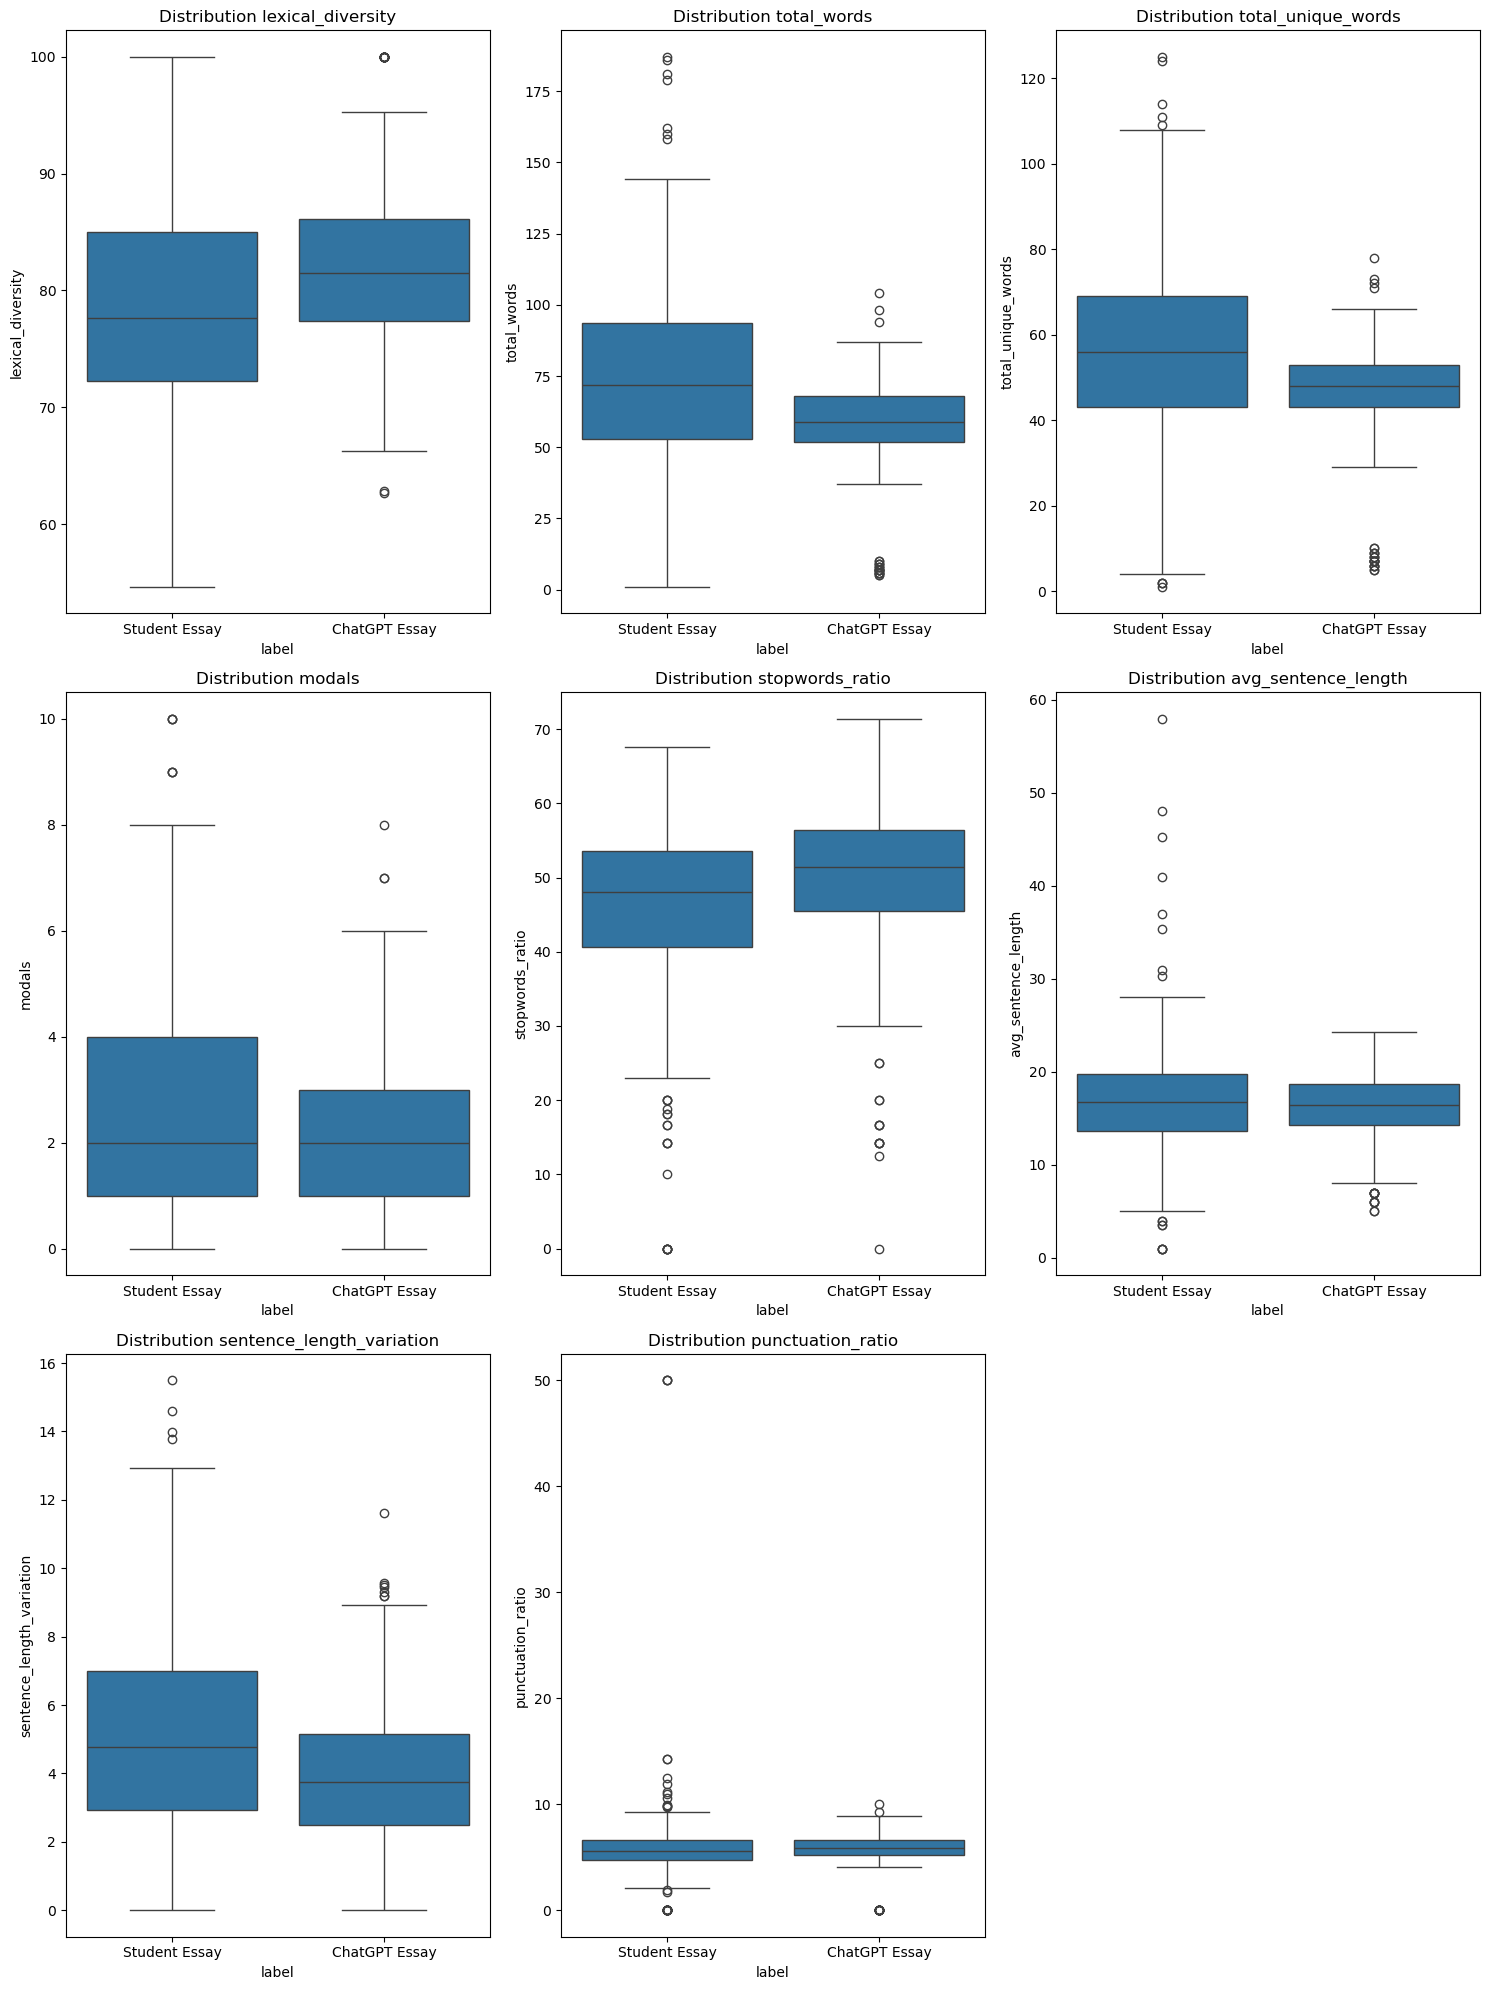

In [33]:
plt.figure(figsize=(15, 20))
for i, feature in enumerate([
    'lexical_diversity',
    'total_words',
    'total_unique_words',
    'modals',
    'stopwords_ratio',
    'avg_sentence_length',
    'sentence_length_variation',
    'punctuation_ratio'
]):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x='label', y=feature, data=combined_features)
    plt.title(f'Distribution {feature}')
plt.tight_layout()
plt.show()

# Generate Embeddings (Training & Validation Sets)

In [34]:
# Generate embeddings for training and validation sets
print("Generating embeddings for Student (training set)...")
std_tr_emb = gen_emb(std_tr_tokens, semantic_model, batch_size=32)
print("Generating embeddings for ChatGPT (training set)...")
gpt_tr_emb = gen_emb(gpt_tr_tokens, semantic_model, batch_size=32)

print("Generating embeddings for Student (validation set)...")
std_va_emb = gen_emb(std_va_tokens, semantic_model, batch_size=32)
print("Generating embeddings for ChatGPT (validation set)...")
gpt_va_emb = gen_emb(gpt_va_tokens, semantic_model, batch_size=32)

Generating embeddings for Student (training set)...
Generating embeddings for ChatGPT (training set)...
Generating embeddings for Student (validation set)...
Generating embeddings for ChatGPT (validation set)...


# Measure Similarity Score (Training & Validation Sets)

In [35]:
# Training set
std_std_tr_sim_scores = []
std_gpt_tr_sim_scores = []
for emb in std_tr_emb:
    avg_similarity = cos_sim(tf.expand_dims(emb, 0), std_tr_emb)
    std_std_tr_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt_tr_emb)
    std_gpt_tr_sim_scores.append(avg_similarity)

gpt_std_tr_sim_scores = []
gpt_gpt_tr_sim_scores = []
for emb in gpt_tr_emb:
    avg_similarity = cos_sim(tf.expand_dims(emb, 0), std_tr_emb)
    gpt_std_tr_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt_tr_emb)
    gpt_gpt_tr_sim_scores.append(avg_similarity)

# Validation set
std_std_va_sim_scores = []
std_gpt_va_sim_scores = []
for emb in std_va_emb:
    avg_similarity = cos_sim(tf.expand_dims(emb, 0), std_va_emb)
    std_std_va_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt_va_emb)
    std_gpt_va_sim_scores.append(avg_similarity)

gpt_std_va_sim_scores = []
gpt_gpt_va_sim_scores = []
for emb in gpt_va_emb:
    avg_similarity = cos_sim(tf.expand_dims(emb, 0), std_va_emb)
    gpt_std_va_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt_va_emb)
    gpt_gpt_va_sim_scores.append(avg_similarity)

std_tr_sim_scores = np.array([
    std_std_tr_sim_scores, 
    std_gpt_tr_sim_scores
])

gpt_tr_sim_scores = np.array([
    gpt_std_tr_sim_scores, 
    gpt_gpt_tr_sim_scores
])

std_va_sim_scores = np.array([
    std_std_va_sim_scores, 
    std_gpt_va_sim_scores
])

gpt_va_sim_scores = np.array([
    gpt_std_va_sim_scores, 
    gpt_gpt_va_sim_scores
])

# Feature Extraction (Training & Validation Sets)

In [36]:
# Feature extraction for Student and ChatGPT essays
print("Features extraction for Student (training set)...")
std_tr_features = [linguistic_features(text) for text in train_set[train_set['label'] == 0]['text'].tolist()]
print("Features extraction for ChatGPT (training set)...")
gpt_tr_features = [linguistic_features(text) for text in train_set[train_set['label'] == 1]['text'].tolist()]

print("Features extraction for Student (validation set)...")
std_va_features = [linguistic_features(text) for text in val_set[val_set['label'] == 0]['text'].tolist()]
print("Features extraction for ChatGPT (validation set)...")
gpt_va_features = [linguistic_features(text) for text in val_set[val_set['label'] == 1]['text'].tolist()]

print("Features extraction for Student (test set)...")
std_te_features = [linguistic_features(text) for text in test_set[test_set['label'] == 0]['text'].tolist()]
print("Features extraction for ChatGPT (test set)...")
gpt_te_features = [linguistic_features(text) for text in test_set[test_set['label'] == 1]['text'].tolist()]

# convert
std_tr_features_df = pd.DataFrame(std_tr_features)
gpt_tr_features_df = pd.DataFrame(gpt_tr_features)

std_va_features_df = pd.DataFrame(std_va_features)
gpt_va_features_df = pd.DataFrame(gpt_va_features)

std_te_features_df = pd.DataFrame(std_te_features)
gpt_te_features_df = pd.DataFrame(gpt_te_features)

# Show the first few rows of the features DataFrames
print("\nStudent Linguistic Features (Training Set):")
display(std_tr_features_df.head())

print("\nChatGPT Linguistic Features (Training Set):")
display(gpt_tr_features_df.head())

Features extraction for Student (training set)...
Features extraction for ChatGPT (training set)...
Features extraction for Student (validation set)...
Features extraction for ChatGPT (validation set)...
Features extraction for Student (test set)...
Features extraction for ChatGPT (test set)...

Student Linguistic Features (Training Set):


,lexical_diversity,total_words,total_unique_words,modals,stopwords_ratio,avg_sentence_length,sentence_length_variation,punctuation_ratio
0,92.307692,39,36,2,51.282051,13.000000,1.414214,7.692308
1,76.785714,56,43,4,55.357143,18.666667,5.436502,5.357143
2,82.653061,98,81,0,36.734694,10.888889,7.030796,9.183673
3,69.135802,81,56,2,58.024691,20.250000,3.561952,4.938272
4,73.949580,119,88,4,48.739496,14.875000,3.950870,6.722689



ChatGPT Linguistic Features (Training Set):


,lexical_diversity,total_words,total_unique_words,modals,stopwords_ratio,avg_sentence_length,sentence_length_variation,punctuation_ratio
0,88.372093,43,38,0,51.162791,10.75,4.264681,9.302326
1,75.714286,70,53,5,64.285714,17.50,4.609772,5.714286
2,82.539683,63,52,2,52.380952,15.75,3.269174,6.349206
3,83.018868,53,44,0,56.603774,13.25,2.680951,7.547170
4,74.647887,71,53,3,63.380282,17.75,3.269174,5.633803


# Normalize Linguistic Features (Training & Validation Sets)

In [37]:
# Combine features into a single DataFrame
all_tr_features = pd.concat([std_tr_features_df, gpt_tr_features_df], axis=0)
all_va_features = pd.concat([std_va_features_df, gpt_va_features_df], axis=0)
all_te_features = pd.concat([std_te_features_df, gpt_te_features_df], axis=0)

# Normalize features
scaler = StandardScaler()
normalized_tr_features = scaler.fit_transform(all_tr_features)
normalized_va_features = scaler.fit_transform(all_va_features)
normalized_te_features = scaler.fit_transform(all_te_features)

# Separate normalized features back into student and ChatGPT
n_student_tr = len(std_tr_features_df)
n_chatgpt_tr = len(gpt_tr_features_df)

n_student_va = len(std_va_features_df)
n_chatgpt_va = len(gpt_va_features_df)

n_student_te = len(std_te_features_df)
n_chatgpt_te = len(gpt_te_features_df)

std_tr_features_norm = normalized_tr_features[:n_student_tr]
gpt_tr_features_norm = normalized_tr_features[n_student_tr:n_student_tr + n_chatgpt_tr]

std_va_features_norm = normalized_va_features[:n_student_va]
gpt_va_features_norm = normalized_va_features[n_student_va:n_student_va + n_chatgpt_va]

std_te_features_norm = normalized_te_features[:n_student_te]
gpt_te_features_norm = normalized_te_features[n_student_te:n_student_te + n_chatgpt_te]

print("Student features after normalization (training):")
print(std_tr_features_norm[:5])

print("ChatGPT features after normalization (training):")
print(gpt_tr_features_norm[:5])

Student features after normalization (training):
[[ 1.22129827 -0.86690841 -0.70540245 -0.06478619  0.2957318  -0.6969402
  -1.09915261  0.5110904 ]
 [-0.42780993 -0.29874468 -0.36201922  0.99252446  0.65097812  0.41919707
   0.31202465 -0.10989935]
 [ 0.19555714  1.10495394  1.50206115 -1.12209684 -0.97243482 -1.11275605
   0.87136589  0.9076889 ]
 [-1.2405628   0.53679021  0.27569249 -0.06478619  0.8835218   0.73105895
  -0.34564147 -0.22128967]
 [-0.72913058  1.80680326  1.84544438  0.99252446  0.0740844  -0.32763007
  -0.20919356  0.25323998]]
ChatGPT features after normalization (training):
[[ 0.8031667  -0.73322283 -0.60729295 -1.12209684  0.28533525 -1.14011235
  -0.09909652  0.93924202]
 [-0.54164217  0.16915486  0.12852825  1.52117978  1.42932679  0.1894041
   0.02197524 -0.01492445]
 [ 0.1835114  -0.06479491  0.0794735  -0.06478619  0.39152856 -0.15528535
  -0.44835935  0.15391982]
 [ 0.2344217  -0.39900887 -0.31296447 -1.12209684  0.75965322 -0.64769885
  -0.65473111  0.4724

In [38]:
# Check dimensions of your embedding arrays
print("std_te_emb shape:", std_te_emb.shape)
print("gpt_te_emb shape:", gpt_te_emb.shape)


# Print shapes of the resulting similarity scores
print("std_std_tr_sim_scores shape:", np.array(std_std_te_sim_scores).shape)
print("std_gpt_tr_sim_scores shape:", np.array(std_gpt_te_sim_scores).shape)
print("gpt_std_tr_sim_scores shape:", np.array(gpt_std_te_sim_scores).shape)
print("gpt_gpt_tr_sim_scores shape:", np.array(gpt_gpt_te_sim_scores).shape)

# Check shapes of the combined arrays
print("std_tr_sim_scores shape:", std_te_sim_scores.shape)
print("gpt_tr_sim_scores shape:", gpt_te_sim_scores.shape)

std_te_emb shape: (109, 256)
gpt_te_emb shape: (55, 256)
std_std_tr_sim_scores shape: (109,)
std_gpt_tr_sim_scores shape: (109,)
gpt_std_tr_sim_scores shape: (55,)
gpt_gpt_tr_sim_scores shape: (55,)
std_tr_sim_scores shape: (2, 109)
gpt_tr_sim_scores shape: (2, 55)


In [39]:
# Combine embeddings for model 1 (already correct)
emb_tr_features = np.vstack([std_tr_emb, gpt_tr_emb])
emb_va_features = np.vstack([std_va_emb, gpt_va_emb])
emb_te_features = np.vstack([std_te_emb, gpt_te_emb])

std_tr_features_selected = std_tr_features_norm
gpt_tr_features_selected = gpt_tr_features_norm

std_va_features_selected = std_va_features_norm
gpt_va_features_selected = gpt_va_features_norm

std_te_features_selected = std_te_features_norm
gpt_te_features_selected = gpt_te_features_norm

linguistic_tr_features = np.vstack([
    std_tr_features_selected,
    gpt_tr_features_selected
])
linguistic_va_features = np.vstack([
    std_va_features_selected,
    gpt_va_features_selected
])
linguistic_te_features = np.vstack([
    std_te_features_selected,
    gpt_te_features_selected
])

std_tr_sim_scores_transposed = std_tr_sim_scores.T 
gpt_tr_sim_scores_transposed = gpt_tr_sim_scores.T
similarity_tr_scores = np.vstack([
    std_tr_sim_scores_transposed,
    gpt_tr_sim_scores_transposed,
])

std_va_sim_scores_transposed = std_va_sim_scores.T 
gpt_va_sim_scores_transposed = gpt_va_sim_scores.T
similarity_va_scores = np.vstack([
    std_va_sim_scores_transposed,
    gpt_va_sim_scores_transposed,
])
std_te_sim_scores_transposed = std_te_sim_scores.T 
gpt_te_sim_scores_transposed = gpt_te_sim_scores.T
similarity_te_scores = np.vstack([
    std_te_sim_scores_transposed,
    gpt_te_sim_scores_transposed,
])

# Create labels
std_tr_labels = np.zeros(len(std_tr_emb))  # Label 0 for Student
gpt_tr_labels = np.ones(len(gpt_tr_emb))   # Label 1 for ChatGPT
tr_labels = np.hstack([std_tr_labels, gpt_tr_labels])

std_va_labels = np.zeros(len(std_va_emb))
gpt_va_labels = np.ones(len(gpt_va_emb))
va_labels = np.hstack([std_va_labels, gpt_va_labels])

std_te_labels = np.zeros(len(std_te_emb))
gpt_te_labels = np.ones(len(gpt_te_emb))
te_labels = np.hstack([std_te_labels, gpt_te_labels])

tr_labels = tr_labels.astype(int)
va_labels = va_labels.astype(int)
te_labels = te_labels.astype(int)

# Verify shapes
print(f"emb_tr_features shape: {emb_tr_features.shape}")
print(f"linguistic_tr_features shape: {linguistic_tr_features.shape}")
print(f"similarity_tr_scores shape: {similarity_tr_scores.shape}")
print(f"tr_labels shape: {tr_labels.shape}")
print(f"tr_labels value: {tr_labels}")


emb_tr_features shape: (408, 256)
linguistic_tr_features shape: (408, 8)
similarity_tr_scores shape: (408, 2)
tr_labels shape: (408,)
tr_labels value: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1]


# Build Classification Model

In [40]:
emb_input = tf.keras.layers.Input(
    shape=(256,),
    dtype=tf.float32, 
    name="embeddings"
)

sim_score_input = tf.keras.layers.Input(
    shape=(2,),  # Shape score similarity (Student, ChatGPT1, ChatGPT2)
    dtype=tf.float32, 
    name="similarity_score"
)

linguistic_input = tf.keras.layers.Input(
    shape=(8,),
    dtype=tf.float32, 
    name="linguistic_features"
)

emb_dense = tf.keras.layers.Dense(256, activation="relu")(emb_input)
sim_dense = tf.keras.layers.Dense(16, activation="relu")(sim_score_input)
lin_dense = tf.keras.layers.Dense(64, activation="relu")(linguistic_input)

combined = tf.keras.layers.Concatenate()([emb_dense, sim_dense, lin_dense])

x = tf.keras.layers.Dense(128, activation="relu")(combined)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
output = tf.keras.layers.Dense(1, activation="sigmoid")(x)

classifier = tf.keras.Model(
    inputs=[emb_input, sim_score_input, linguistic_input],
    outputs=output,
    name="text_classifier"
)

classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

classifier.summary()

Model: "text_classifier"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 embeddings (InputLayer)     [(None, 256)]                0         []                            
                                                                                                  
 similarity_score (InputLay  [(None, 2)]                  0         []                            
 er)                                                                                              
                                                                                                  
 linguistic_features (Input  [(None, 8)]                  0         []                            
 Layer)                                                                                           
                                                                                    

In [41]:
train_inputs = {
    "embeddings": emb_tr_features[tr_labels],
    "similarity_score": similarity_tr_scores[tr_labels],
    "linguistic_features": linguistic_tr_features[tr_labels]
}

val_inputs = {
    "embeddings": emb_va_features[va_labels],
    "similarity_score": similarity_va_scores[va_labels],
    "linguistic_features": linguistic_va_features[va_labels]
}


test_inputs = {
    "embeddings": emb_te_features[te_labels],
    "similarity_score": similarity_te_scores[te_labels],
    "linguistic_features": linguistic_te_features[te_labels]
}

train_labels = tr_labels
val_labels = va_labels
test_labels = te_labels

Training Classification Model...
Epoch 1/20
13/13 [==============================] - 2s 25ms/step - loss: 0.6759 - accuracy: 0.5735 - precision: 0.8571 - recall: 0.1765 - auc: 0.8092 - val_loss: 0.6916 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 2/20
13/13 [==============================] - 0s 13ms/step - loss: 0.6183 - accuracy: 0.9412 - precision: 1.0000 - recall: 0.8824 - auc: 0.9991 - val_loss: 0.6838 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 3/20
13/13 [==============================] - 0s 9ms/step - loss: 0.5619 - accuracy: 0.9975 - precision: 1.0000 - recall: 0.9951 - auc: 1.0000 - val_loss: 0.6772 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 4/20
13/13 [==============================] - 0s 9ms/step - loss: 0.5061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.6730 - val_accuracy: 0.5000 - va

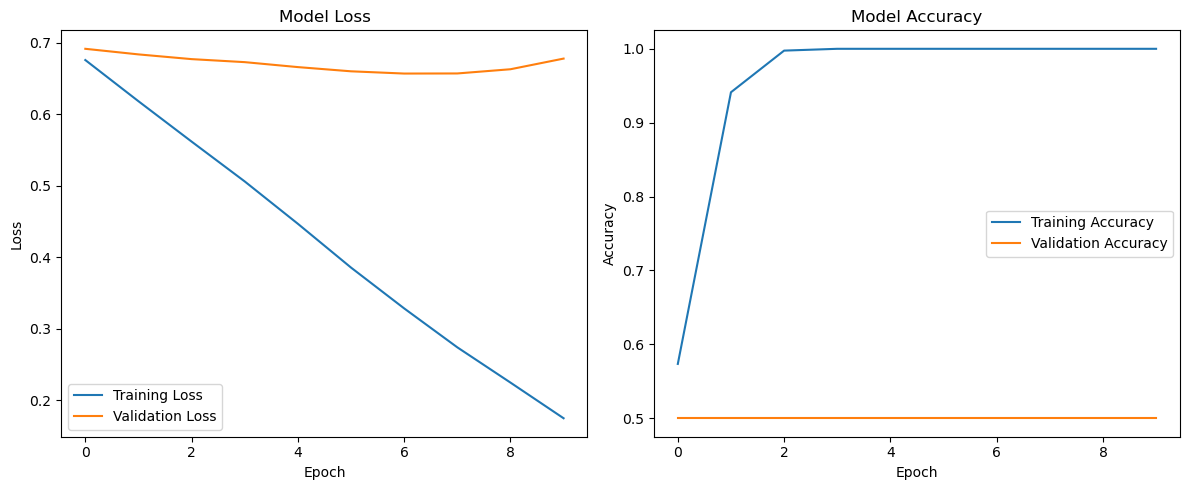

In [42]:
# Training classifier
print("Training Classification Model...")
history_classifier = classifier.fit(
    train_inputs,
    train_labels,
    validation_data=(val_inputs, val_labels),
    epochs=20,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_classifier.history['loss'], label='Training Loss')
plt.plot(history_classifier.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_classifier.history['accuracy'], label='Training Accuracy')
plt.plot(history_classifier.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Evaluating model on validation set...
1/1 [==============================] - 0s 25ms/step - loss: 0.6570 - accuracy: 0.5000 - precision: 0.5000 - recall: 1.0000 - auc: 1.0000
Validation Loss: 0.6570
Validation Accuracy: 0.5000
Validation Precision: 0.5000
Validation Recall: 1.0000
Validation AUC: 1.0000
Making predictions on validation set...
1/1 [==============================] - 0s 48ms/step


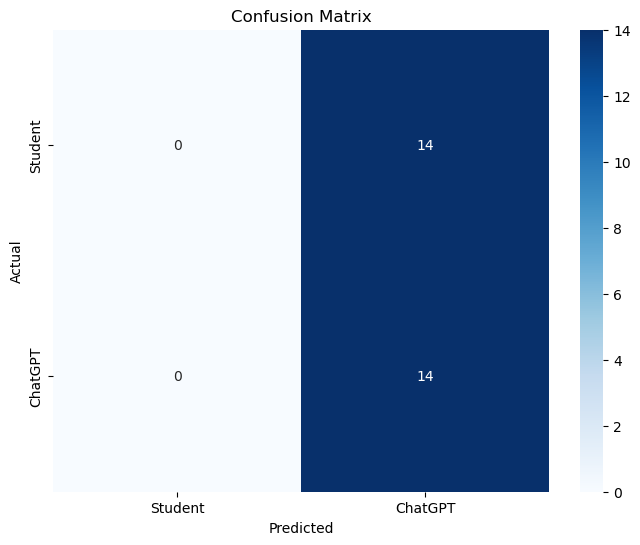


Classification Report:
              precision    recall  f1-score   support

     Student       0.00      0.00      0.00        14
     ChatGPT       0.50      1.00      0.67        14

    accuracy                           0.50        28
   macro avg       0.25      0.50      0.33        28
weighted avg       0.25      0.50      0.33        28

Evaluating model on test set...
6/6 [==============================] - 0s 5ms/step - loss: 0.6797 - accuracy: 0.3354 - precision: 0.3354 - recall: 1.0000 - auc: 1.0000            
Test Loss: 0.6797
Test Accuracy: 0.3354
Test Precision: 0.3354
Test Recall: 1.0000
Test AUC: 1.0000
Making predictions on test set...
6/6 [==============================] - 0s 2ms/step


/home/training/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/training/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/training/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


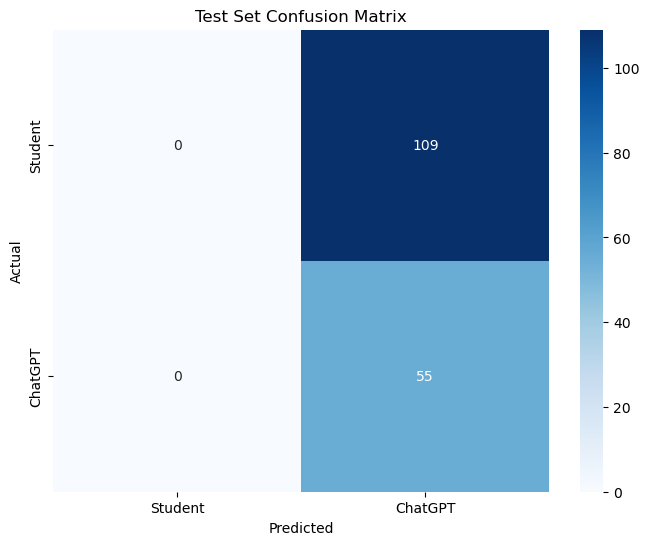


Test Set Classification Report:
              precision    recall  f1-score   support

     Student       0.00      0.00      0.00       109
     ChatGPT       0.34      1.00      0.50        55

    accuracy                           0.34       164
   macro avg       0.17      0.50      0.25       164
weighted avg       0.11      0.34      0.17       164



/home/training/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/training/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/training/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [43]:
# Model evaluation
print("Evaluating model on validation set...")
val_loss, val_acc, val_precision, val_recall, val_auc = classifier.evaluate(val_inputs, val_labels)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation AUC: {val_auc:.4f}")

# Predictions on validation set
print("Making predictions on validation set...")
val_predictions = classifier.predict(val_inputs)
val_predictions_binary = (val_predictions > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(val_labels, val_predictions_binary)

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Student', 'ChatGPT'], yticklabels=['Student', 'ChatGPT'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(val_labels, val_predictions_binary, target_names=['Student', 'ChatGPT']))

# Model evaluation on test set
print("Evaluating model on test set...")
test_loss, test_acc, test_precision, test_recall, test_auc = classifier.evaluate(test_inputs, test_labels)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Predictions on test set
print("Making predictions on test set...")
test_predictions = classifier.predict(test_inputs)
test_predictions_binary = (test_predictions > 0.5).astype(int)

# Confusion matrix for test set
cm_test = confusion_matrix(test_labels, test_predictions_binary)

# Visualizing confusion matrix for test set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Student', 'ChatGPT'], yticklabels=['Student', 'ChatGPT'])
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report for test set
print("\nTest Set Classification Report:")
print(classification_report(test_labels, test_predictions_binary, target_names=['Student', 'ChatGPT']))


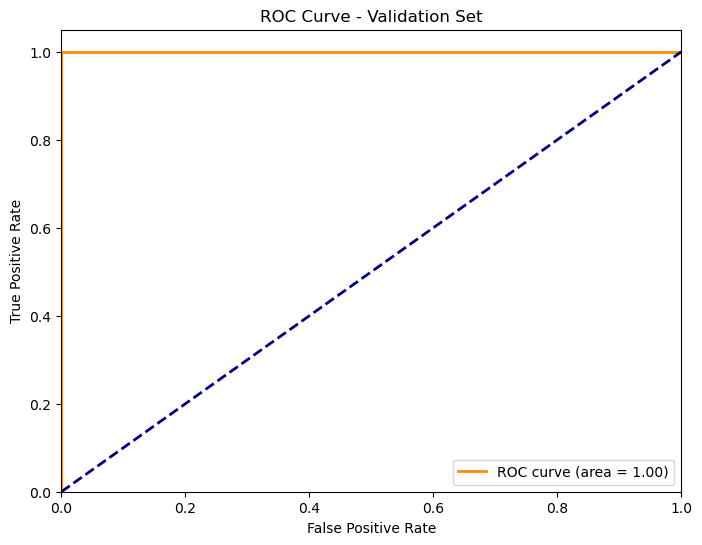

Validation AUC from ROC curve: 1.0000


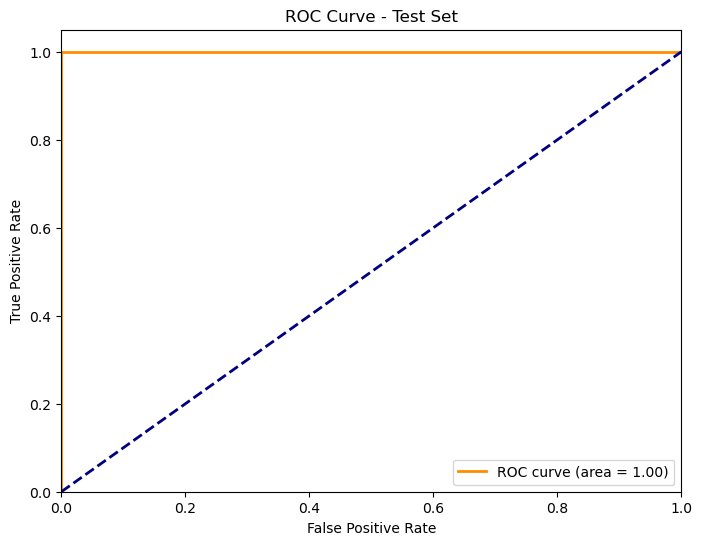

Test AUC from ROC curve: 1.0000


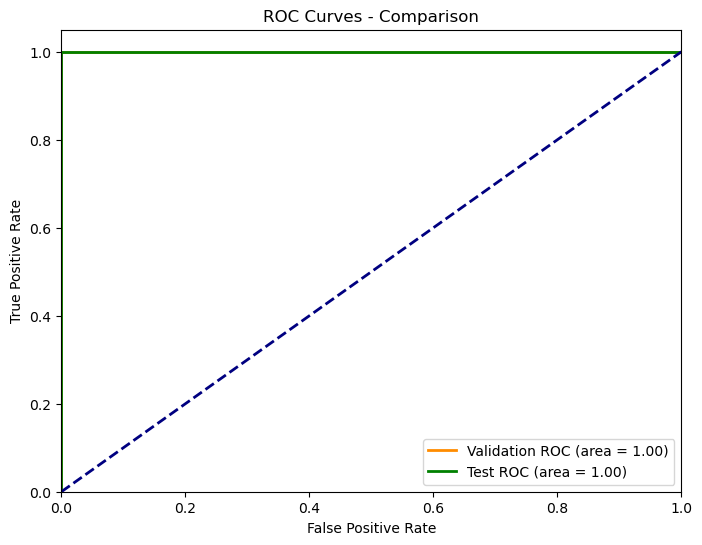

In [44]:
# Plot ROC curve
def plot_roc_curve(labels, predictions, title):
    fpr, tpr, _ = roc_curve(labels, predictions)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {title}')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc

# Plot ROC curve for validation set
val_auc_score = plot_roc_curve(val_labels, val_predictions, "Validation Set")
print(f"Validation AUC from ROC curve: {val_auc_score:.4f}")

# Plot ROC curve for test set
test_auc_score = plot_roc_curve(test_labels, test_predictions, "Test Set")
print(f"Test AUC from ROC curve: {test_auc_score:.4f}")

# Plot both ROC curves in one graph for comparison
plt.figure(figsize=(8, 6))

# Validation set
fpr_val, tpr_val, _ = roc_curve(val_labels, val_predictions)
roc_auc_val = auc(fpr_val, tpr_val)
plt.plot(fpr_val, tpr_val, color='darkorange', lw=2, label=f'Validation ROC (area = {roc_auc_val:.2f})')

# Test set
fpr_test, tpr_test, _ = roc_curve(test_labels, test_predictions)
roc_auc_test = auc(fpr_test, tpr_test)
plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Test ROC (area = {roc_auc_test:.2f})')

# Diagonal line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Comparison')
plt.legend(loc="lower right")
plt.show()

In [45]:
if not os.path.exists('paper'):
    os.makedirs('paper')

semantic_model.save('paper/semantic_model.h5')
classifier.save('paper/classification_model.h5')

tokenizer.save_pretrained('paper/tokenizer')

with open("paper/scaler_linguistic.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("Model and configuration successfully saved!")

/home/training/anaconda3/lib/python3.12/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model and configuration successfully saved!


In [46]:
%load_ext watermark
%watermark
%watermark -iv --gpu

Last updated: 2025-05-05T23:42:26.121532+07:00

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.27.0

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 5.15.167.4-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 24
Architecture: 64bit

tensorflow  : 2.19.0
seaborn     : 0.13.2
sklearn     : 1.5.1
numpy       : 1.26.4
transformers: 4.39.3
matplotlib  : 3.9.2
re          : 2.2.1
imblearn    : 0.12.3
pandas      : 2.2.2

GPU Info: 
  GPU 0: NVIDIA GeForce RTX 4060 Ti

